# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 25 May 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
# under50s
u50 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u50, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    u50,
                 "30-39":    u50,
                 "18-29":    u50,
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

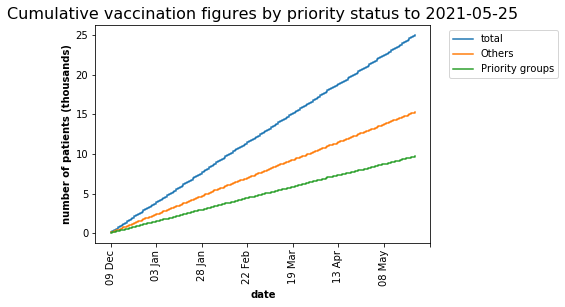

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

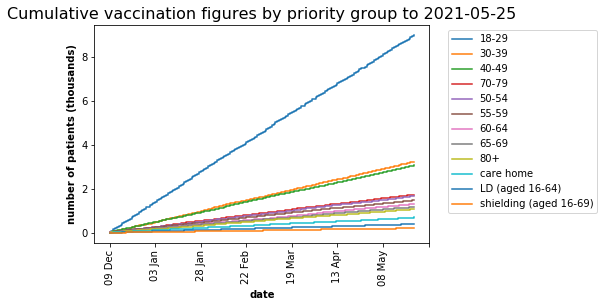

In [15]:
make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [15]:
from report_results import summarise_data_by_group

In [16]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [17]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [18]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [19]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [20]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

In [21]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)))    
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 25 May 2021,second dose as at 25 May 2021
Total vaccinated in TPP,"24,997","15,001"
80+,"50.4% (1,064 of 2,114)","29.0% (616 of 2,114)"
70-79,"49.6% (1,729 of 3,486)","30.6% (1,071 of 3,486)"
care home,"51.3% (693 of 1,351)","28.9% (392 of 1,351)"
shielding (aged 16-69),48.4% (210 of 434),29.5% (126 of 434)
65-69,"51.4% (1,169 of 2,275)","30.2% (686 of 2,275)"
LD (aged 16-64),49.3% (392 of 791),28.4% (224 of 791)
60-64,"48.9% (1,309 of 2,674)","31.9% (854 of 2,674)"
55-59,"49.0% (1,484 of 3,024)","29.8% (903 of 3,024)"
50-54,"50.0% (1,666 of 3,332)","29.7% (994 of 3,332)"


*
 figures rounded to nearest 7

In [22]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.0%** (7)

Pfizer vaccines (% of all first doses): **0.2%** (49)

Moderna vaccines (% of all first doses): **0.0%** (0)

Second doses (% of all vaccinated): **60.0%** (15,001)

Second doses (% of Ox-AZ first doses): **99500.0%** (6,965)

Second doses (% of Pfizer first doses): **10814.3%** (5,299)

Second doses (% of Moderna first doses): **0%** (7,182)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [23]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1065   
sex                       F                                           518   
                          M                                           546   
ageband_5yr               0                                            63   
                          0-15                                         70   
                          16-29                                        56   
                          30-34                                        77   
                          35-39                                        56   
                          40-44                                        63   
                          45-49                                        56   
                          50-54                                        84   
                          55-59                                        70   
                          60-64                                        63   
                          65-69                                        63   
                          70-74                                        70   
                          75-79                                        56   
                          80-84                                        70   
                          85-89                                        77   
                          90+                                          70   
ethnicity_6_groups        Black                                       189   
                          Mixed                                       168   
                          Other                                       175   
                          South Asian                                 182   
                          Unknown                                     154   
                          White                                       196   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   63   
                           Chinese                                     63   
                           Other                                       63   
                           Other Asian                                 49   
                          British or Mixed British                     49   
                          Indian or British Indian                     56   
                          Irish                                        63   
                          Other Black                                  56   
                          Other White                                  49   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               56   
                          Unknown                                     154   
                          White + Asian                                49   
                          White + Black African                        63   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             203   
                          2                                           203   
                          3                                           196   
                          4                                           210   
                          5 Least deprived                            203   
                          Unknown                                      49   
bmi                       30+                                         343   
                          under 30                                    728   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1728   
sex                       F                                           889   
                          M                                           833   
ageband_5yr               0                                            98   
                          0-15                                        119   
                          16-29                                        98   
                          30-34                                        98   
                          35-39                                        91   
                          40-44                                       126   
                          45-49                                       126   
                          50-54                                       112   
                          55-59                                       112   
                          60-64                                       105   
                          65-69                                        98   
                          70-74                                       126   
                          75-79                                       112   
                          80-84                                        91   
                          85-89                                       105   
                          90+                                         112   
ethnicity_6_groups        Black                                       280   
                          Mixed                                       287   
                          Other                                       287   
                          South Asian                                 301   
                          Unknown                                     273   
                          White                                       294   
ethnicity_16_groups        African                                     84   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   98   
                           Chinese                                     98   
                           Other                                       77   
                           Other Asian                                 84   
                          British or Mixed British                     84   
                          Indian or British Indian                     91   
                          Irish                                        91   
                          Other Black                                 105   
                          Other White                                  98   
                          Other mixed                                 119   
                          Pakistani or British Pakistani               91   
                          Unknown                                     273   
                          White + Asian                                77   
                          White + Black African                        84   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             350   
                          2                                           301   
                          3                                           343   
                          4                                           336   
                          5 Least deprived                            322   
                          Unknown                                      77   
bmi                       30+                                         497   
                          under 30                                   1232   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose) among **care home** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             693     51.3   1351   
sex                F                   364     53.1    686   
                   M                   329     49.0    672   
ageband_5yr        0                    42     50.0     84   
                   0-15                 42     42.9     98   
                   16-29                35     45.5     77   
                   30-34                49     58.3     84   
                   35-39                42     60.0     70   
                   40-44                42     50.0     84   
                   45-49                35     50.0     70   
                   50-54                42     46.2     91   
                   55-59                35     50.0     70   
                   60-64                42     54.5     77   
                   65-69                42     54.5     77   
                   70-74                42     46.2     91   
                   75-79                49     53.8     91   
                   80-84                56     57.1     98   
                   85-89                49     50.0     98   
                   90+                  49     50.0     98   
ethnicity_6_groups Black                98     48.3    203   
                   Mixed               119     48.6    245   
                   Other               119     51.5    231   
                   South Asian         112     53.3    210   
                   Unknown             126     54.5    231   
                   White               112     50.0    224   
dementia           no                  686     51.0   1344   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 48.8   
sex                F                                         50   
                   M                                       46.9   
ageband_5yr        0                                         50   
                   0-15                                    42.9   
                   16-29                                   45.5   
                   30-34                                   58.3   
                   35-39                                     60   
                   40-44                                   41.7   
                   45-49                                     50   
                   50-54                                   46.2   
                   55-59                                     50   
                   60-64                                   54.5   
                   65-69                                   54.5   
                   70-74                                   38.5   
                   75-79                                   53.8   
                   80-84                                     50   
                   85-89                                     50   
                   90+                                       50   
ethnicity_6_groups Black                                   44.8   
                   Mixed                                   48.6   
                   Other                                   48.5   
                   South Asian                             53.3   
                   Unknown                                 54.5   
                   White                                   46.9   
dementia           no                                        49   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.5   
sex                F                                     3.1   
                   M             

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  210     48.4    434   
newly_shielded_since_feb_15 no                       210     49.2    427   
                            yes                        0      0.0      0   
sex                         F                         98     48.3    203   
                            M                        112     50.0    224   
ageband                     16-29                     21     42.9     49   
                            30-39                     28     50.0     56   
                            40-49                     28     50.0     56   
                            50-59                     21     37.5     56   
                            60-69                     28     50.0     56   
                            70-79                     56     53.3    105   
                            80+                       35     62.5     56   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     28     36.4     77   
                            Other                     42     60.0     70   
                            South Asian               42     54.5     77   
                            Unknown                   28     44.4     63   
                            White                     42     54.5     77   
imd_categories              1 Most deprived           42     42.9     98   
                            2                         42     42.9     98   
                            3                         35     45.5     77   
                            4                         35     50.0     70   
                            5 Least deprived          42     60.0     70   
                            Unknown                    7     33.3     21   
LD                          no                       210     49.2    427   
                            yes                        0      0.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      45.9   
newly_shielded_since_feb_15 no                                           45.9   
                            yes                                           NaN   
sex                         F                                            44.8   
                            M                                            46.9   
ageband                     16-29                                        28.6   
                            30-39                                          50   
                            40-49                                        37.5   
                            50-59                                        37.5   
                            60-69                                          50   
                            70-79                                        46.7   
                            80+                                          62.5   
ethnicity_6_groups          Black                                        36.4   
                            Mixed                                        36.4   
                            Other                                          60   
                            South Asian                                  45.5   
                            Unknown                                      44.4   
                            White                                        45.5   
imd_categories              1 Most deprived                              42.9   
                            2                                            42.9   
                            3                                            36.4   
                            4                         

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1170   
sex                       F                                           595   
                          M                                           574   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       217   
                          Other                                       203   
                          South Asian                                 203   
                          Unknown                                     154   
                          White                                       189   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   56   
                           Chinese                                     70   
                           Other                                       49   
                           Other Asian                                 56   
                          British or Mixed British                     56   
                          Indian or British Indian                     70   
                          Irish                                        63   
                          Other Black                                  77   
                          Other White                                  63   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               63   
                          Unknown                                     182   
                          White + Asian                                70   
                          White + Black African                        63   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             210   
                          2                                           231   
                          3                                           210   
                          4                                           238   
                          5 Least deprived                            217   
                          Unknown                                      56   
bmi                       30+                                         329   
                          under 30                                    840   
chronic_cardiac_disease   no                                         1155   
                          yes                                          14   
current_copd              no                                         1155   
                          yes                                          14   
dmards                    no                                         1162   
                          yes                                           7   
dementia                  no                                         1155   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1162   
                          yes                                           7   
LD                        no                                         1155   
                          yes                                          14   
ssri                      no                                         1155   
                          yes                                          14   
chemo_or_radio            no                                         1162   
                          yes                                          14   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             390     49.3    791   
sex                F                   203     49.2    413   
                   M                   189     50.0    378   
ageband_5yr        0                    21     42.9     49   
                   0-15                 21     42.9     49   
                   16-29                21     50.0     42   
                   30-34                21     42.9     49   
                   35-39                28     57.1     49   
                   40-44                21     60.0     35   
                   45-49                28     57.1     49   
                   50-54                28     50.0     56   
                   55-59                21     50.0     42   
                   60-64                21     42.9     49   
                   65-69                28     44.4     63   
                   70-74                28     44.4     63   
                   75-79                35     62.5     56   
                   80-84                21     50.0     42   
                   85-89                28     57.1     49   
                   90+                  21     42.9     49   
ethnicity_6_groups Black                49     41.2    119   
                   Mixed                70     50.0    140   
                   Other                77     55.0    140   
                   South Asian          56     42.1    133   
                   Unknown              63     52.9    119   
                   White                77     52.4    147   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 47.4   
sex                F                                       47.5   
                   M                                       48.1   
ageband_5yr        0                                       42.9   
                   0-15                                    42.9   
                   16-29                                     50   
                   30-34                                   42.9   
                   35-39                                   57.1   
                   40-44                                     40   
                   45-49                                   57.1   
                   50-54                                     50   
                   55-59                                     50   
                   60-64                                   42.9   
                   65-69                                   44.4   
                   70-74                                   33.3   
                   75-79                                     50   
                   80-84                                     50   
                   85-89                                   57.1   
                   90+                                     42.9   
ethnicity_6_groups Black                                   41.2   
                   Mixed                                     50   
                   Other                                     50   
                   South Asian                             36.8   
                   Unknown                                 52.9   
                   White                                   47.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.9   
sex                F                                     1.7   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   16-29                                   0   
                   30-34           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1307   
sex                       F                                           658   
                          M                                           644   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       210   
                          Other                                       245   
                          South Asian                                 210   
                          Unknown                                     217   
                          White                                       224   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   63   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 84   
                          British or Mixed British                     70   
                          Indian or British Indian                     63   
                          Irish                                        77   
                          Other Black                                  63   
                          Other White                                  70   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               77   
                          Unknown                                     217   
                          White + Asian                                70   
                          White + Black African                        84   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             259   
                          2                                           245   
                          3                                           252   
                          4                                           238   
                          5 Least deprived                            259   
                          Unknown                                      63   
bmi                       30+                                         392   
                          under 30                                    917   
chronic_cardiac_disease   no                                         1295   
                          yes                                           7   
current_copd              no                                         1295   
                          yes                                          14   
dmards                    no                                         1288   
                          yes                                          14   
dementia                  no                                         1295   
                          yes                                           7   
psychosis_schiz_bipolar   no                                         1295   
                          yes                                          14   
ssri                      no                                         1295   
                          yes                                          14   
chemo_or_radio            no                                         1288   
                          yes                                          21   
lung_cancer               no                                         1302   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1481   
sex                     F                                           763   
                        M                                           721   
ethnicity_6_groups      Black                                       259   
                        Mixed                                       287   
                        Other                                       252   
                        South Asian                                 231   
                        Unknown                                     217   
                        White                                       231   
ethnicity_16_groups      African                                     84   
                         Bangladeshi or British Bangladeshi          70   
                         Caribbean                                   63   
                         Chinese                                     91   
                         Other                                       84   
                         Other Asian                                 84   
                        British or Mixed British                     91   
                        Indian or British Indian                     84   
                        Irish                                        70   
                        Other Black                                  91   
                        Other White                                  84   
                        Other mixed                                  77   
                        Pakistani or British Pakistani               84   
                        Unknown                                     210   
                        White + Asian                                70   
                        White + Black African                        77   
                        White + Black Caribbean                      77   
imd_categories          1 Most deprived                             259   
                        2                                           315   
                        3                                           287   
                        4                                           294   
                        5 Least deprived                            252   
                        Unknown                                      70   
bmi                     30+                                         476   
                        under 30                                   1008   
chronic_cardiac_disease no                                         1463   
                        yes                                          21   
current_copd            no                                         1470   
                        yes                                          14   
dmards                  no                                         1470   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1470   
                        yes                                          14   
ssri                    no                                         1463   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 49.0   3024   
sex                     F                                       49.1   1554   
                        M                                       49.0   1470   
ethnicity_6_groups      Black                                   54.4    476   
                        Mixed                                   51.2    560   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1665   
sex                     F                                           847   
                        M                                           812   
ethnicity_6_groups      Black                                       301   
                        Mixed                                       301   
                        Other                                       266   
                        South Asian                                 252   
                        Unknown                                     266   
                        White                                       280   
ethnicity_16_groups      African                                     91   
                         Bangladeshi or British Bangladeshi          91   
                         Caribbean                                   91   
                         Chinese                                     77   
                         Other                                       98   
                         Other Asian                                 84   
                        British or Mixed British                    105   
                        Indian or British Indian                    105   
                        Irish                                        77   
                        Other Black                                  91   
                        Other White                                  77   
                        Other mixed                                  84   
                        Pakistani or British Pakistani               84   
                        Unknown                                     245   
                        White + Asian                                91   
                        White + Black African                        70   
                        White + Black Caribbean                      98   
imd_categories          1 Most deprived                             294   
                        2                                           294   
                        3                                           308   
                        4                                           322   
                        5 Least deprived                            336   
                        Unknown                                     105   
bmi                     30+                                         518   
                        under 30                                   1148   
chronic_cardiac_disease no                                         1652   
                        yes                                           7   
current_copd            no                                         1652   
                        yes                                          14   
dmards                  no                                         1652   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1638   
                        yes                                          28   
ssri                    no                                         1645   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 50.0   3332   
sex                     F                                       48.4   1750   
                        M                                       51.3   1582   
ethnicity_6_groups      Black                                   51.8    581   
                        Mixed                                   51.8    581   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **40-49** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3064     49.8   
sex                 F                                          1589     50.1   
                    M                                          1470     49.2   
ethnicity_6_groups  Black                                       518     49.7   
                    Mixed                                       532     50.0   
                    Other                                       525     48.7   
                    South Asian                                 525     49.7   
                    Unknown                                     476     52.7   
                    White                                       490     48.6   
ethnicity_16_groups  African                                    168     51.1   
                     Bangladeshi or British Bangladeshi         168     53.3   
                     Caribbean                                  182     53.1   
                     Chinese                                    168     50.0   
                     Other                                      161     50.0   
                     Other Asian                                175     53.2   
                    British or Mixed British                    175     49.0   
                    Indian or British Indian                    168     53.3   
                    Irish                                       175     50.0   
                    Other Black                                 154     48.9   
                    Other White                                 140     43.5   
                    Other mixed                                 147     43.8   
                    Pakistani or British Pakistani              154     48.9   
                    Unknown                                     441     48.5   
                    White + Asian                               168     49.0   
                    White + Black African                       168     54.5   
                    White + Black Caribbean                     154     48.9   
imd_categories      1 Most deprived                             581     49.7   
                    2                                           602     50.3   
                    3                                           574     47.7   
                    4                                           560     48.8   
                    5 Least deprived                            588     52.5   
                    Unknown                                     161     51.1   

                                                         total  \
category            group                                        
overall             overall                               6153   
sex                 F                                     3171   
                    M                                     2989   
ethnicity_6_groups  Black                                 1043   
                    Mixed                                 1064   
                    Other                                 1078   
                    South Asian                           1057   
                    Unknown                                903   
                    White                                 1008   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               336   
                     Other                                 322   
                     Other Asian                           329   
                    British or Mixed British               357   
                    Indian or British Indian               315   
                    Irish                                  350   
                

## 

## COVID vaccination rollout (first dose) among **30-39** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3236     50.1   
sex                 F                                          1596     48.7   
                    M                                          1638     51.4   
ethnicity_6_groups  Black                                       546     51.3   
                    Mixed                                       560     49.4   
                    Other                                       539     49.4   
                    South Asian                                 532     49.4   
                    Unknown                                     476     49.6   
                    White                                       581     50.9   
ethnicity_16_groups  African                                    175     49.0   
                     Bangladeshi or British Bangladeshi         154     45.8   
                     Caribbean                                  189     52.9   
                     Chinese                                    196     52.8   
                     Other                                      182     54.2   
                     Other Asian                                161     48.9   
                    British or Mixed British                    189     54.0   
                    Indian or British Indian                    175     52.1   
                    Irish                                       168     49.0   
                    Other Black                                 147     47.7   
                    Other White                                 161     50.0   
                    Other mixed                                 175     48.1   
                    Pakistani or British Pakistani              175     49.0   
                    Unknown                                     483     50.0   
                    White + Asian                               182     51.0   
                    White + Black African                       161     46.0   
                    White + Black Caribbean                     168     51.1   
imd_categories      1 Most deprived                             581     48.3   
                    2                                           651     50.8   
                    3                                           595     49.4   
                    4                                           637     52.0   
                    5 Least deprived                            602     50.0   
                    Unknown                                     175     51.0   

                                                         total  \
category            group                                        
overall             overall                               6461   
sex                 F                                     3276   
                    M                                     3185   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1134   
                    Other                                 1092   
                    South Asian                           1078   
                    Unknown                                959   
                    White                                 1141   
ethnicity_16_groups  African                               357   
                     Bangladeshi or British Bangladeshi    336   
                     Caribbean                             357   
                     Chinese                               371   
                     Other                                 336   
                     Other Asian                           329   
                    British or Mixed British               350   
                    Indian or British Indian               336   
                    Irish                                  343   
                

## 

## COVID vaccination rollout (first dose) among **18-29** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    8991     50.2   
sex                 F                                          4641     50.7   
                    M                                          4354     49.8   
ethnicity_6_groups  Black                                      1589     49.7   
                    Mixed                                      1575     51.1   
                    Other                                      1484     50.0   
                    South Asian                                1470     48.8   
                    Unknown                                    1386     51.4   
                    White                                      1491     50.5   
ethnicity_16_groups  African                                    497     50.4   
                     Bangladeshi or British Bangladeshi         476     50.0   
                     Caribbean                                  490     50.7   
                     Chinese                                    441     48.1   
                     Other                                      462     48.9   
                     Other Asian                                483     52.7   
                    British or Mixed British                    441     47.7   
                    Indian or British Indian                    511     52.9   
                    Irish                                       469     48.6   
                    Other Black                                 469     48.9   
                    Other White                                 476     51.1   
                    Other mixed                                 483     48.6   
                    Pakistani or British Pakistani              490     51.1   
                    Unknown                                    1358     50.0   
                    White + Asian                               476     48.2   
                    White + Black African                       490     54.7   
                    White + Black Caribbean                     469     51.5   
imd_categories      1 Most deprived                            1694     49.6   
                    2                                          1680     49.7   
                    3                                          1750     51.5   
                    4                                          1736     51.5   
                    5 Least deprived                           1708     49.5   
                    Unknown                                     427     48.0   

                                                         total  \
category            group                                        
overall             overall                              17906   
sex                 F                                     9156   
                    M                                     8743   
ethnicity_6_groups  Black                                 3199   
                    Mixed                                 3080   
                    Other                                 2968   
                    South Asian                           3010   
                    Unknown                               2695   
                    White                                 2954   
ethnicity_16_groups  African                               987   
                     Bangladeshi or British Bangladeshi    952   
                     Caribbean                             966   
                     Chinese                               917   
                     Other                                 945   
                     Other Asian                           917   
                    British or Mixed British               924   
                    Indian or British Indian               966   
                    Irish                                  966   
                

# Demographics time trend charts

In [24]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 25 May 2021

### COVID vaccinations among **80+** population by **sex**

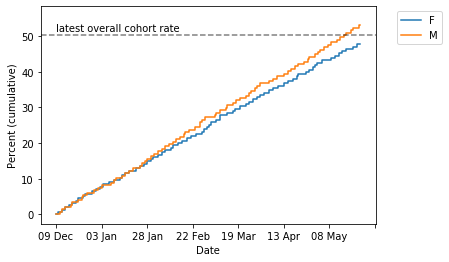

### COVID vaccinations among **80+** population by **ageband 5yr**

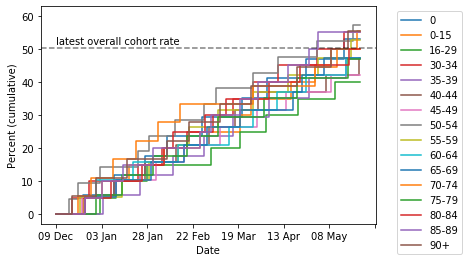

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

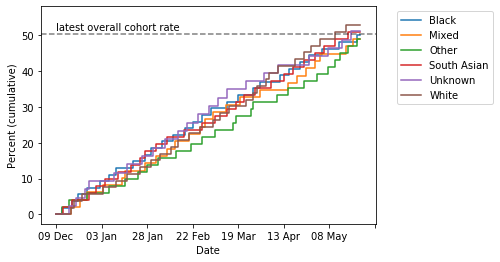

### COVID vaccinations among **80+** population by **imd categories**

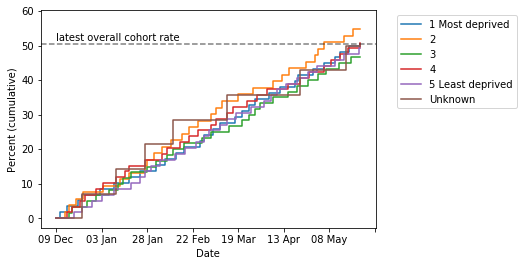

### COVID vaccinations among **80+** population by **bmi**

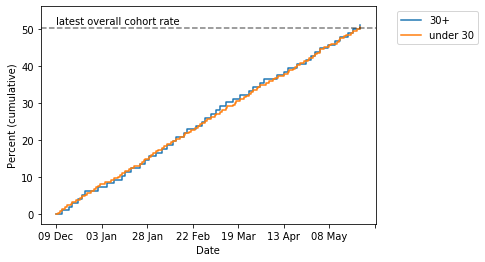

### COVID vaccinations among **80+** population by **dialysis**

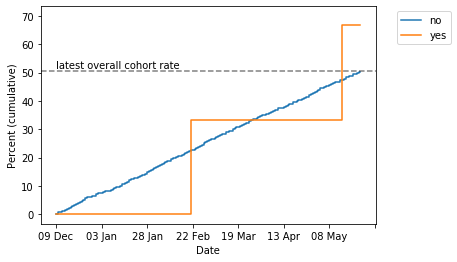

### COVID vaccinations among **80+** population by **dementia**

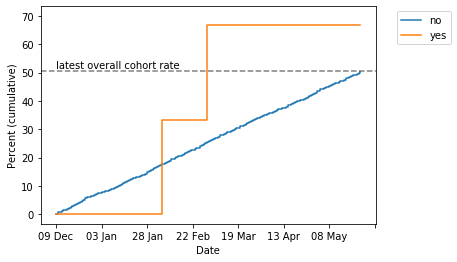

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

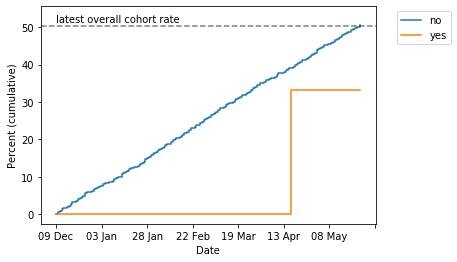

### COVID vaccinations among **80+** population by **LD**

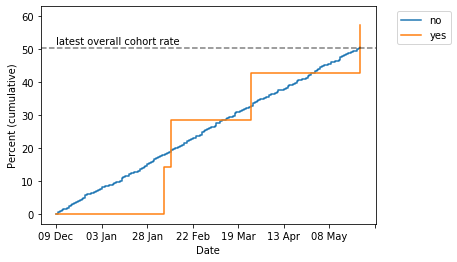

### COVID vaccinations among **80+** population by **ssri**

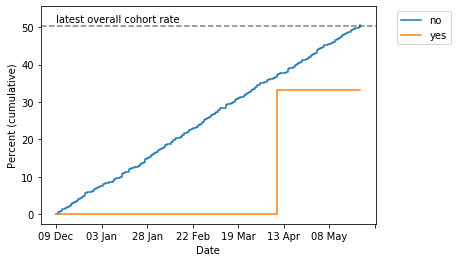

## 
 ## COVID vaccination rollout among **70-79** population up to 25 May 2021

### COVID vaccinations among **70-79** population by **sex**

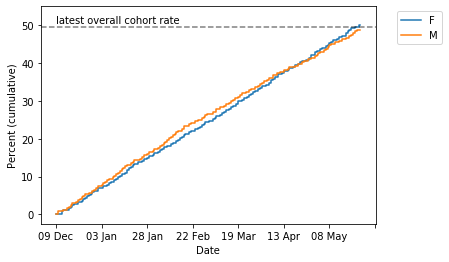

### COVID vaccinations among **70-79** population by **ageband 5yr**

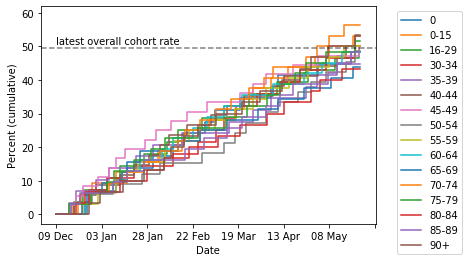

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

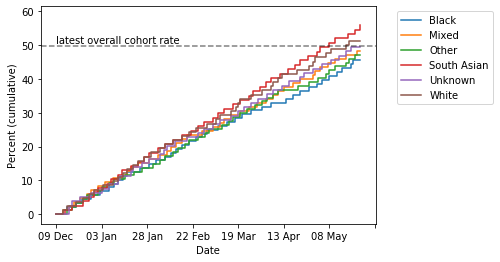

### COVID vaccinations among **70-79** population by **imd categories**

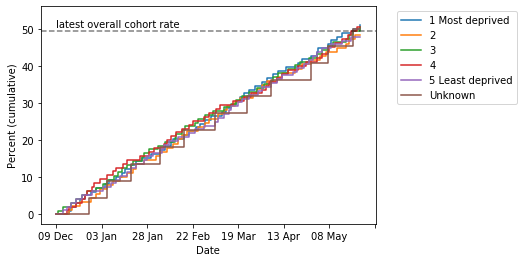

### COVID vaccinations among **70-79** population by **bmi**

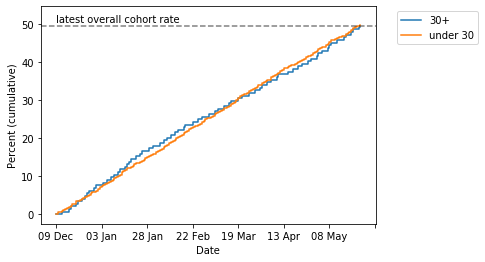

### COVID vaccinations among **70-79** population by **dialysis**

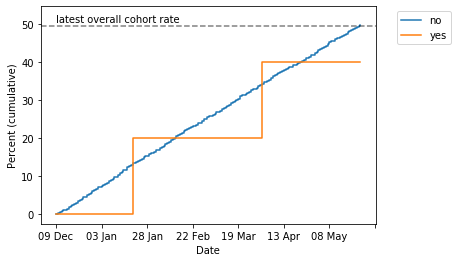

### COVID vaccinations among **70-79** population by **dementia**

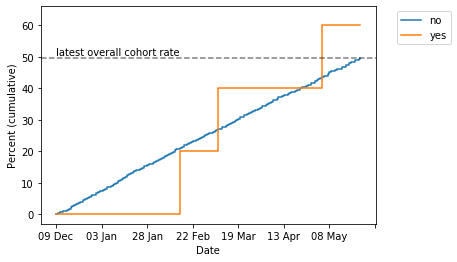

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

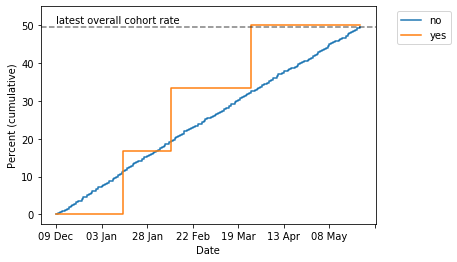

### COVID vaccinations among **70-79** population by **LD**

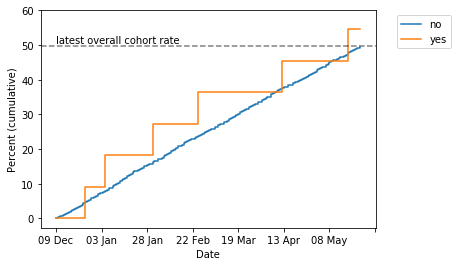

### COVID vaccinations among **70-79** population by **ssri**

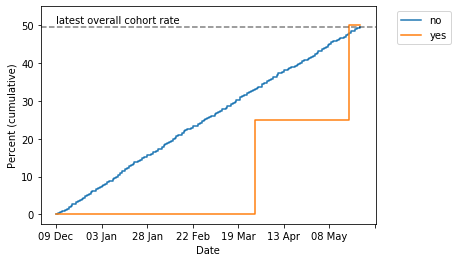

## 
 ## COVID vaccination rollout among **65-69** population up to 25 May 2021

### COVID vaccinations among **65-69** population by **sex**

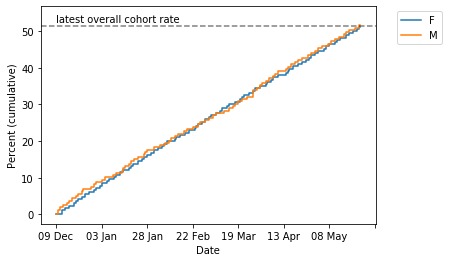

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

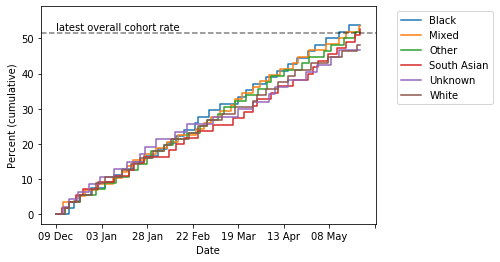

### COVID vaccinations among **65-69** population by **imd categories**

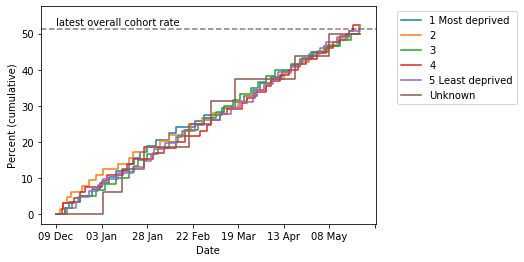

### COVID vaccinations among **65-69** population by **bmi**

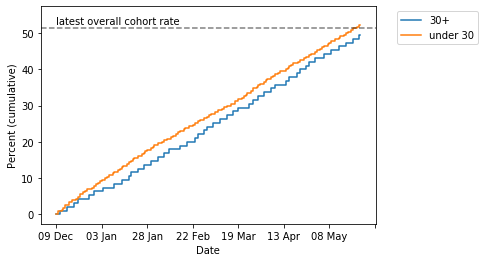

### COVID vaccinations among **65-69** population by **dementia**

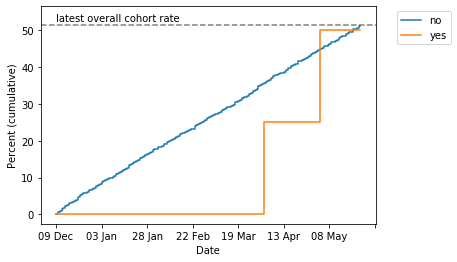

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

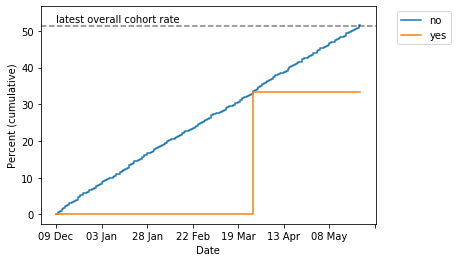

### COVID vaccinations among **65-69** population by **LD**

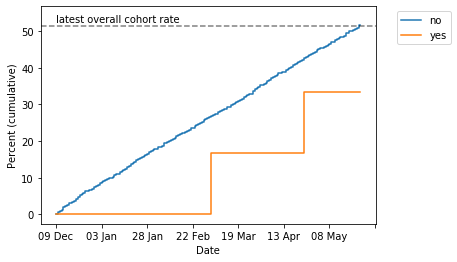

### COVID vaccinations among **65-69** population by **ssri**

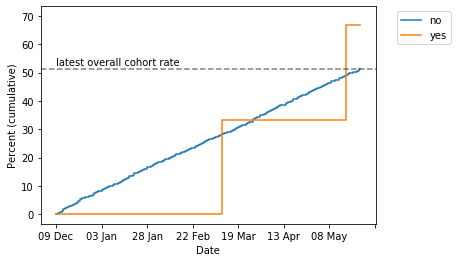

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 25 May 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

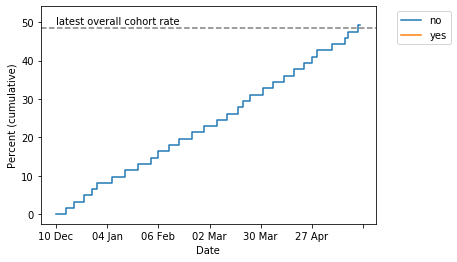

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

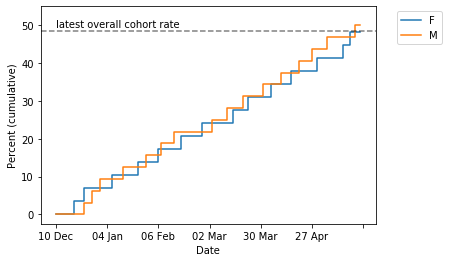

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

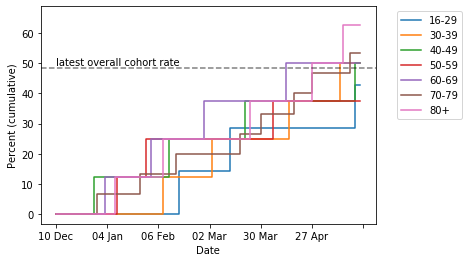

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

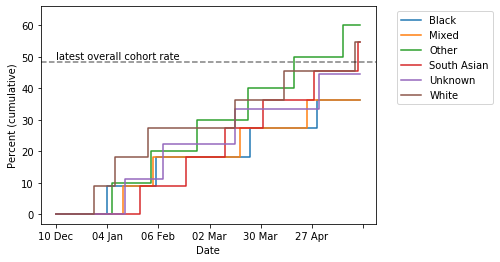

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

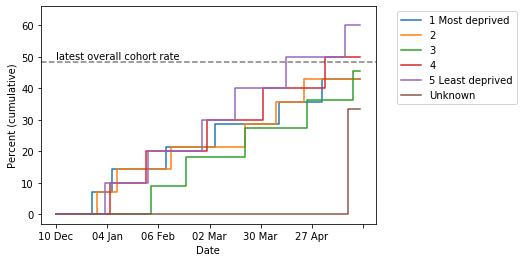

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

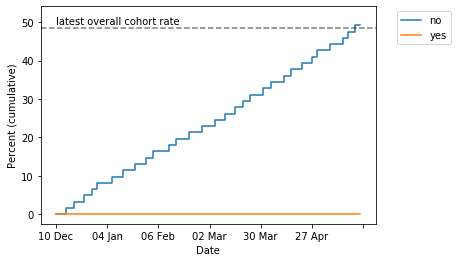

## 
 ## COVID vaccination rollout among **60-64** population up to 25 May 2021

### COVID vaccinations among **60-64** population by **sex**

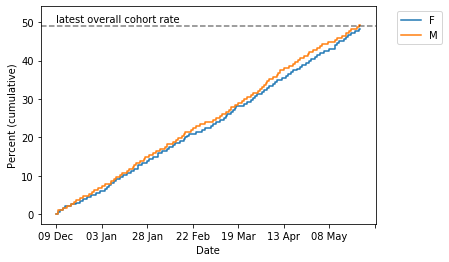

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

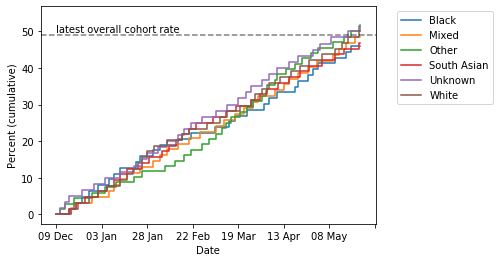

### COVID vaccinations among **60-64** population by **imd categories**

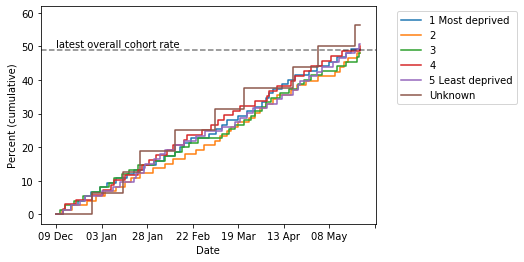

### COVID vaccinations among **60-64** population by **bmi**

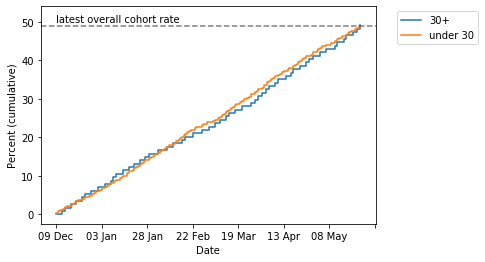

### COVID vaccinations among **60-64** population by **dementia**

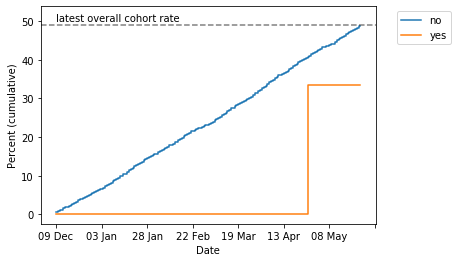

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

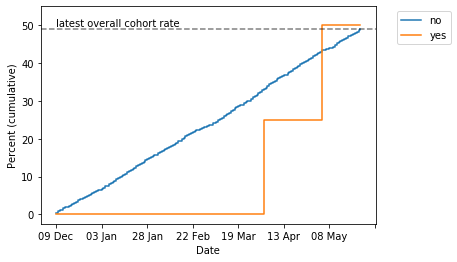

### COVID vaccinations among **60-64** population by **ssri**

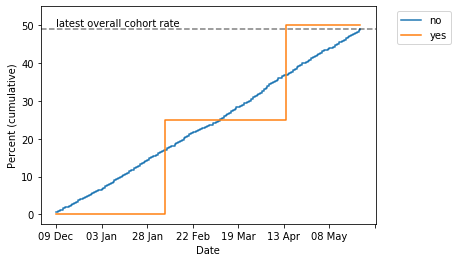

## 
 ## COVID vaccination rollout among **55-59** population up to 25 May 2021

### COVID vaccinations among **55-59** population by **sex**

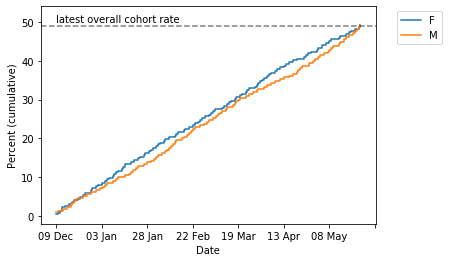

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

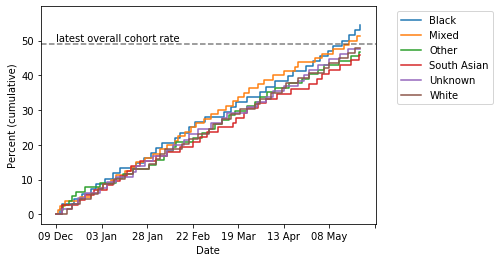

### COVID vaccinations among **55-59** population by **imd categories**

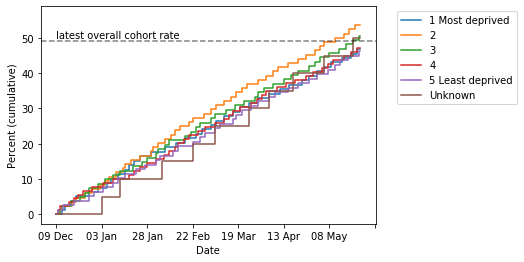

### COVID vaccinations among **55-59** population by **bmi**

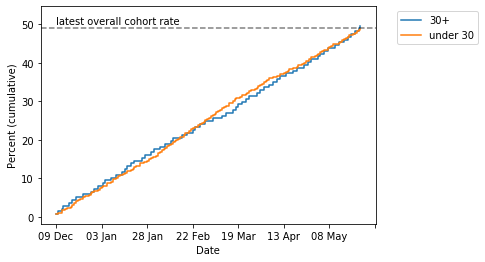

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

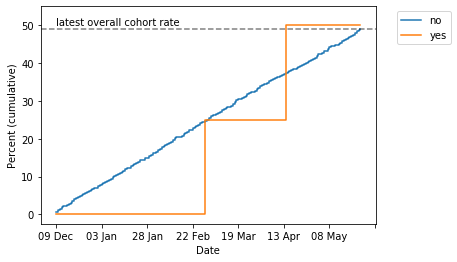

### COVID vaccinations among **55-59** population by **ssri**

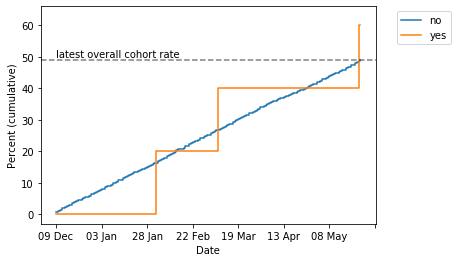

## 
 ## COVID vaccination rollout among **50-54** population up to 25 May 2021

### COVID vaccinations among **50-54** population by **sex**

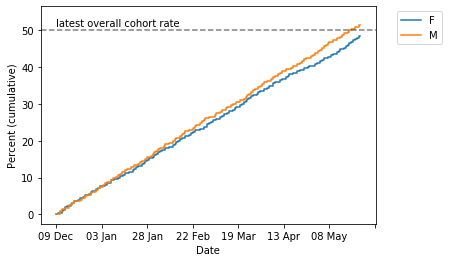

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

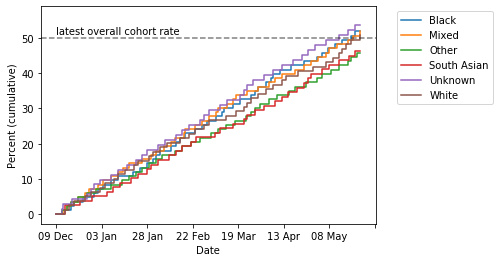

### COVID vaccinations among **50-54** population by **imd categories**

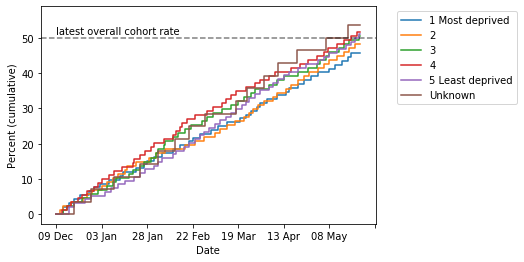

### COVID vaccinations among **50-54** population by **bmi**

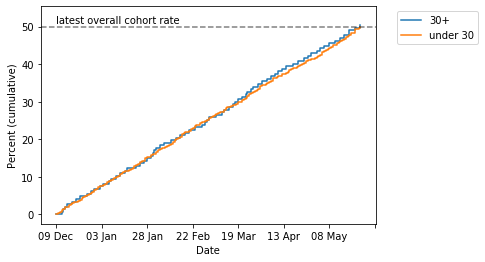

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

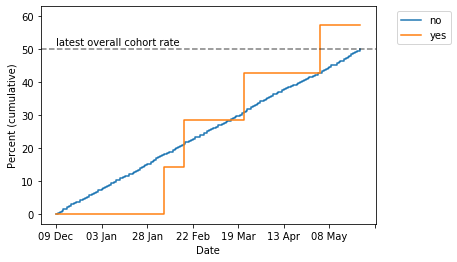

### COVID vaccinations among **50-54** population by **ssri**

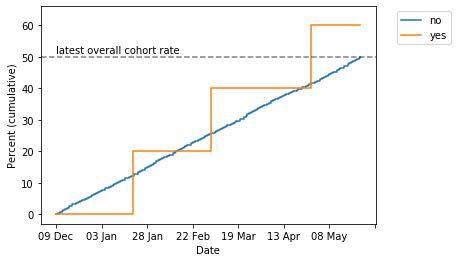

## 
 ## COVID vaccination rollout among **40-49** population up to 25 May 2021

### COVID vaccinations among **40-49** population by **sex**

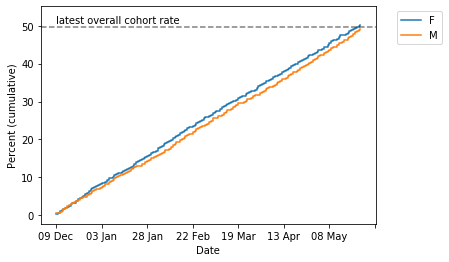

### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

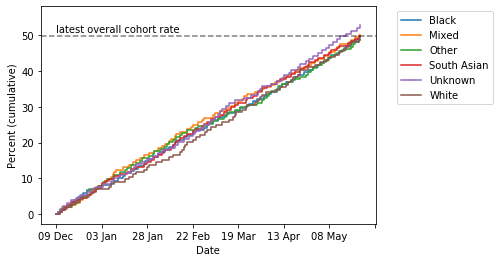

### COVID vaccinations among **40-49** population by **imd categories**

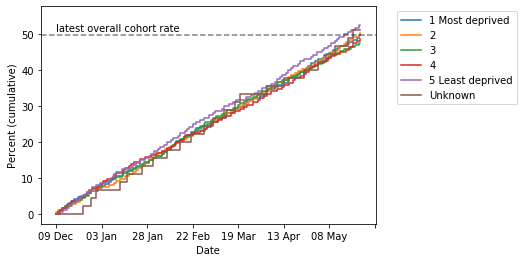

## 
 ## COVID vaccination rollout among **30-39** population up to 25 May 2021

### COVID vaccinations among **30-39** population by **sex**

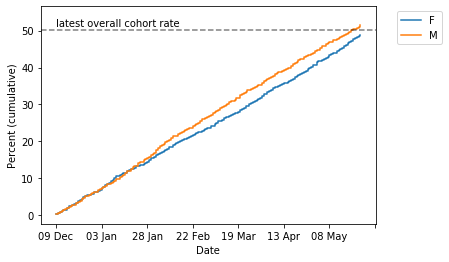

### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

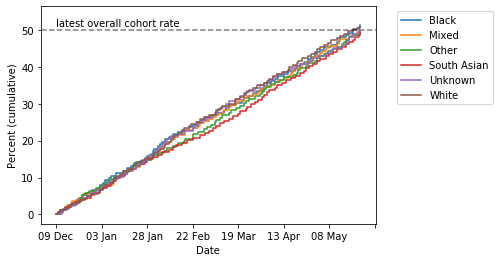

### COVID vaccinations among **30-39** population by **imd categories**

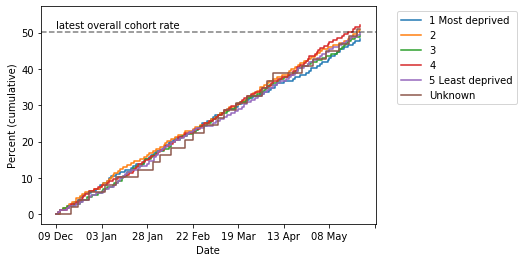

## 
 ## COVID vaccination rollout among **18-29** population up to 25 May 2021

### COVID vaccinations among **18-29** population by **sex**

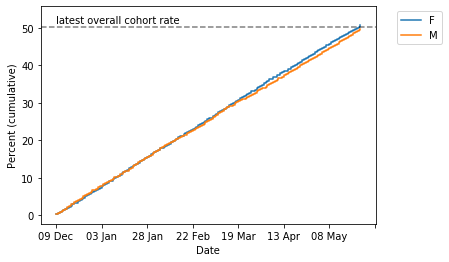

### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

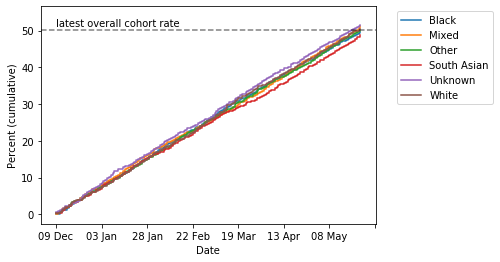

### COVID vaccinations among **18-29** population by **imd categories**

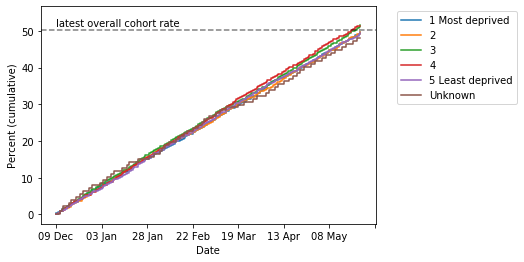

In [25]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [26]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,813 (85.8%)

Total **70-79** population with ethnicity recorded 2,933 (84.1%)

Total **care home** population with ethnicity recorded 1,120 (82.9%)

Total **shielding (aged 16-69)** population with ethnicity recorded 371 (85.5%)

Total **65-69** population with ethnicity recorded 1,946 (85.5%)

Total **LD (aged 16-64)** population with ethnicity recorded 672 (85.0%)

Total **60-64** population with ethnicity recorded 2,247 (84.0%)

Total **55-59** population with ethnicity recorded 2,562 (84.7%)

Total **50-54** population with ethnicity recorded 2,842 (85.3%)

Total **40-49** population with ethnicity recorded 5,250 (85.3%)

Total **30-39** population with ethnicity recorded 5,502 (85.2%)

Total **vaccinated 18-29** population with ethnicity recorded 15,211 (84.9%)

# Second doses

In [27]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

date_14w = pd.to_datetime(df["covid_vacc_date"]).max() - timedelta(weeks=14)
date_14w = str(date_14w)[:10]

df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

formatted_date_14w = datetime.strptime(date_14w, "%Y-%m-%d").strftime("%d %b %Y")
with open(os.path.join(savepath["text"], f"latest_date_of_first_dose_for_due_second_doses.txt"), "w") as text_file:
        text_file.write(formatted_date_14w)
        
display(Markdown(formatted_date_14w))

16 Feb 2021

In [28]:
# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [29]:

df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

In [30]:
second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

In [31]:
create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

## 

## COVID vaccination rollout (second dose) among **80+** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     131   
sex                       F                                            63   
                          M                                            70   
ageband_5yr               0                                             7   
                          0-15                                          0   
                          16-29                                         7   
                          30-34                                         7   
                          35-39                                         0   
                          40-44                                         7   
                          45-49                                         7   
                          50-54                                        14   
                          55-59                                         7   
                          60-64                                         7   
                          65-69                                         0   
                          70-74                                        14   
                          75-79                                         7   
                          80-84                                         7   
                          85-89                                         0   
                          90+                                           7   
ethnicity_6_groups        Black                                        28   
                          Mixed                                        14   
                          Other                                        14   
                          South Asian                                  28   
                          Unknown                                      21   
                          White                                        21   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                    7   
                           Chinese                                     14   
                           Other                                        7   
                           Other Asian                                  7   
                          British or Mixed British                      0   
                          Indian or British Indian                      7   
                          Irish                                         7   
                          Other Black                                   7   
                          Other White                                   0   
                          Other mixed                                   7   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 7   
                          White + Black African                         7   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              28   
                          2                                            21   
                          3                                            21   
                          4                                            21   
                          5 Least deprived                             21   
                          Unknown                                       7   
bmi                       30+                                          49   
                          under 30                                     84   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     217   
sex                       F                                           105   
                          M                                           112   
ageband_5yr               0                                            14   
                          0-15                                         14   
                          16-29                                        14   
                          30-34                                        14   
                          35-39                                        14   
                          40-44                                        14   
                          45-49                                        28   
                          50-54                                        14   
                          55-59                                         7   
                          60-64                                        14   
                          65-69                                        14   
                          70-74                                        14   
                          75-79                                        14   
                          80-84                                        14   
                          85-89                                         7   
                          90+                                          14   
ethnicity_6_groups        Black                                        42   
                          Mixed                                        35   
                          Other                                        42   
                          South Asian                                  28   
                          Unknown                                      28   
                          White                                        42   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                    7   
                           Chinese                                      0   
                           Other                                       14   
                           Other Asian                                 14   
                          British or Mixed British                     14   
                          Indian or British Indian                     14   
                          Irish                                         7   
                          Other Black                                  14   
                          Other White                                   7   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      35   
                          White + Asian                                 0   
                          White + Black African                         7   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              35   
                          2                                            42   
                          3                                            35   
                          4                                            49   
                          5 Least deprived                             42   
                          Unknown                                      14   
bmi                       30+                                          77   
                          under 30                                    140   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (second dose) among **care home** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall              90      6.7   1351   
sex                 F                    49      7.1    686   
                    M                    42      6.2    672   
ageband_5yr         0                     0      0.0     84   
                    0-15                  0      0.0     98   
                    16-29                 0      0.0     77   
                    30-34                 0      0.0     84   
                    35-39                 0      0.0     70   
                    40-44                 0      0.0     84   
                    45-49                 0      0.0     70   
                    50-54                 0      0.0     91   
                    55-59                 7     10.0     70   
                    60-64                 7      9.1     77   
                    65-69                 7      9.1     77   
                    70-74                 0      0.0     91   
                    75-79                 0      0.0     91   
                    80-84                 7      7.1     98   
                    85-89                 7      7.1     98   
                    90+                   0      0.0     98   
ethnicity_6_groups  Black                14      6.9    203   
                    Mixed                 0      0.0    245   
                    Other                14      6.1    231   
                    South Asian          14      6.7    210   
                    Unknown              21      9.1    231   
                    White                21      9.4    224   
dementia            no                   91      6.8   1344   
brand_of_first_dose Unknown              91     13.1    693   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                  6.6   
sex                 F                                        7.1   
                    M                                        6.2   
ageband_5yr         0                                          0   
                    0-15                                       0   
                    16-29                                      0   
                    30-34                                      0   
                    35-39                                      0   
                    40-44                                      0   
                    45-49                                      0   
                    50-54                                      0   
                    55-59                                     10   
                    60-64                                    9.1   
                    65-69                                    9.1   
                    70-74                                      0   
                    75-79                                      0   
                    80-84                                    7.1   
                    85-89                                    7.1   
                    90+                                        0   
ethnicity_6_groups  Black                                    6.9   
                    Mixed                                      0   
                    Other                                    6.1   
                    South Asian                              6.7   
                    Unknown                                  9.1   
                    White                                    9.4   
dementia            no                                       6.8   
brand_of_first_dose Unknown                                 13.1   

                                Uptake over last 7d (percent)  \
category            group                                       
overall             overall                               0.1   
sex                 F                

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   27      6.2    434   
newly_shielded_since_feb_15 no                        28      6.6    427   
                            yes                        0      0.0      0   
sex                         F                         14      6.9    203   
                            M                         14      6.2    224   
ageband                     16-29                      0      0.0     49   
                            30-39                      0      0.0     56   
                            40-49                      0      0.0     56   
                            50-59                      0      0.0     56   
                            60-69                      7     12.5     56   
                            70-79                      7      6.7    105   
                            80+                        0      0.0     56   
ethnicity_6_groups          Black                      0      0.0     77   
                            Mixed                      0      0.0     77   
                            Other                      0      0.0     70   
                            South Asian                0      0.0     77   
                            Unknown                    0      0.0     63   
                            White                      7      9.1     77   
imd_categories              1 Most deprived            0      0.0     98   
                            2                          0      0.0     98   
                            3                          0      0.0     77   
                            4                          7     10.0     70   
                            5 Least deprived           0      0.0     70   
                            Unknown                    0      0.0     21   
LD                          no                        28      6.6    427   
brand_of_first_dose         Unknown                   28     13.3    210   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       5.8   
newly_shielded_since_feb_15 no                                            4.9   
                            yes                                           NaN   
sex                         F                                             3.4   
                            M                                             6.2   
ageband                     16-29                                           0   
                            30-39                                           0   
                            40-49                                           0   
                            50-59                                           0   
                            60-69                                           0   
                            70-79                                         6.7   
                            80+                                             0   
ethnicity_6_groups          Black                                           0   
                            Mixed                                           0   
                            Other                                           0   
                            South Asian                                     0   
                            Unknown                                         0   
                            White                                           0   
imd_categories              1 Most deprived                                 0   
                            2                                               0   
                            3                                               0   
                            4                         

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     147   
sex                       F                                            77   
                          M                                            70   
ethnicity_6_groups        Black                                        21   
                          Mixed                                        21   
                          Other                                        28   
                          South Asian                                  28   
                          Unknown                                      21   
                          White                                        28   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                   14   
                           Chinese                                     14   
                           Other                                        0   
                           Other Asian                                  7   
                          British or Mixed British                      7   
                          Indian or British Indian                      7   
                          Irish                                         0   
                          Other Black                                   7   
                          Other White                                   7   
                          Other mixed                                   7   
                          Pakistani or British Pakistani                7   
                          Unknown                                      21   
                          White + Asian                                 0   
                          White + Black African                         0   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              28   
                          2                                            28   
                          3                                            28   
                          4                                            28   
                          5 Least deprived                             28   
                          Unknown                                       7   
bmi                       30+                                          35   
                          under 30                                    112   
chronic_cardiac_disease   no                                          147   
                          yes                                           0   
current_copd              no                                          147   
                          yes                                           0   
dmards                    no                                          147   
dementia                  no                                          147   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          147   
                          yes                                           0   
LD                        no                                          147   
                          yes                                           0   
ssri                      no                                          147   
                          yes                                           0   
chemo_or_radio            no                                          147   
lung_cancer               no                                          147   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall              42      5.3    791   
sex                 F                    21      5.1    413   
                    M                    21      5.6    378   
ageband_5yr         0                     0      0.0     49   
                    16-29                 0      0.0     42   
                    30-34                 0      0.0     49   
                    35-39                 0      0.0     49   
                    40-44                 0      0.0     35   
                    45-49                 0      0.0     49   
                    50-54                 0      0.0     56   
                    55-59                 0      0.0     42   
                    60-64                 0      0.0     49   
                    65-69                 0      0.0     63   
                    70-74                 0      0.0     63   
                    75-79                 0      0.0     56   
                    80-84                 0      0.0     42   
                    85-89                 0      0.0     49   
                    90+                   0      0.0     49   
ethnicity_6_groups  Black                 0      0.0    119   
                    Mixed                 7      5.0    140   
                    Other                 7      5.0    140   
                    South Asian           0      0.0    133   
                    Unknown               7      5.9    119   
                    White                14      9.5    147   
brand_of_first_dose Unknown              42     10.7    392   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                  5.1   
sex                 F                                        5.1   
                    M                                        3.7   
ageband_5yr         0                                          0   
                    16-29                                      0   
                    30-34                                      0   
                    35-39                                      0   
                    40-44                                      0   
                    45-49                                      0   
                    50-54                                      0   
                    55-59                                      0   
                    60-64                                      0   
                    65-69                                      0   
                    70-74                                      0   
                    75-79                                      0   
                    80-84                                      0   
                    85-89                                      0   
                    90+                                        0   
ethnicity_6_groups  Black                                      0   
                    Mixed                                      5   
                    Other                                      5   
                    South Asian                                0   
                    Unknown                                    0   
                    White                                    9.5   
brand_of_first_dose Unknown                                 10.7   

                                Uptake over last 7d (percent)  \
category            group                                       
overall             overall                               0.2   
sex                 F                                       0   
                    M                                     1.9   
ageband_5yr         0                                       0   
                    16-29                                   0   
                    30-34              

## 

## COVID vaccination rollout (second dose) among **60-64** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     170   
sex                       F                                            91   
                          M                                            84   
ethnicity_6_groups        Black                                        28   
                          Mixed                                        21   
                          Other                                        21   
                          South Asian                                  35   
                          Unknown                                      28   
                          White                                        35   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi           7   
                           Caribbean                                    0   
                           Chinese                                      7   
                           Other                                        7   
                           Other Asian                                  7   
                          British or Mixed British                     14   
                          Indian or British Indian                      0   
                          Irish                                         0   
                          Other Black                                   7   
                          Other White                                   7   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      28   
                          White + Asian                                14   
                          White + Black African                         7   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              35   
                          2                                            21   
                          3                                            35   
                          4                                            35   
                          5 Least deprived                             35   
                          Unknown                                       7   
bmi                       30+                                          42   
                          under 30                                    133   
chronic_cardiac_disease   no                                          168   
                          yes                                           0   
current_copd              no                                          168   
                          yes                                           0   
dmards                    no                                          168   
                          yes                                           0   
dementia                  no                                          168   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          168   
                          yes                                           0   
ssri                      no                                          168   
                          yes                                           0   
chemo_or_radio            no                                          168   
                          yes                                           0   
lung_cancer               no                                          168   
cancer_excl_lung_and_haem no                                          168   
                          yes                              

## 

## COVID vaccination rollout (second dose) among **55-59** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     169   
sex                     F                                            84   
                        M                                            84   
ethnicity_6_groups      Black                                        28   
                        Mixed                                        42   
                        Other                                        28   
                        South Asian                                  21   
                        Unknown                                      21   
                        White                                        28   
ethnicity_16_groups      African                                      7   
                         Bangladeshi or British Bangladeshi           7   
                         Caribbean                                    7   
                         Chinese                                      7   
                         Other                                        7   
                         Other Asian                                 14   
                        British or Mixed British                      7   
                        Indian or British Indian                      7   
                        Irish                                         7   
                        Other Black                                  14   
                        Other White                                   7   
                        Other mixed                                   7   
                        Pakistani or British Pakistani               14   
                        Unknown                                      21   
                        White + Asian                                14   
                        White + Black African                         0   
                        White + Black Caribbean                      14   
imd_categories          1 Most deprived                              28   
                        2                                            42   
                        3                                            35   
                        4                                            35   
                        5 Least deprived                             28   
                        Unknown                                       7   
bmi                     30+                                          56   
                        under 30                                    119   
chronic_cardiac_disease no                                          168   
                        yes                                           0   
current_copd            no                                          168   
                        yes                                           0   
dmards                  no                                          168   
psychosis_schiz_bipolar no                                          168   
                        yes                                           0   
ssri                    no                                          168   
                        yes                                           0   
brand_of_first_dose     Pfizer                                        0   
                        Unknown                                     168   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  5.6   3024   
sex                     F                                        5.4   1554   
                        M                                        5.7   1470   
ethnicity_6_groups      Black                                    5.9    476   
                        Mixed                                

## 

## COVID vaccination rollout (second dose) among **50-54** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     209   
sex                     F                                           119   
                        M                                            91   
ethnicity_6_groups      Black                                        42   
                        Mixed                                        42   
                        Other                                        21   
                        South Asian                                  35   
                        Unknown                                      35   
                        White                                        28   
ethnicity_16_groups      African                                     14   
                         Bangladeshi or British Bangladeshi          14   
                         Caribbean                                   14   
                         Chinese                                      7   
                         Other                                        7   
                         Other Asian                                  7   
                        British or Mixed British                     14   
                        Indian or British Indian                     14   
                        Irish                                        14   
                        Other Black                                  14   
                        Other White                                   7   
                        Other mixed                                  14   
                        Pakistani or British Pakistani                7   
                        Unknown                                      28   
                        White + Asian                                14   
                        White + Black African                         0   
                        White + Black Caribbean                      14   
imd_categories          1 Most deprived                              42   
                        2                                            35   
                        3                                            42   
                        4                                            42   
                        5 Least deprived                             42   
                        Unknown                                       7   
bmi                     30+                                          56   
                        under 30                                    147   
chronic_cardiac_disease no                                          210   
                        yes                                           0   
current_copd            no                                          210   
                        yes                                           0   
dmards                  no                                          210   
                        yes                                           0   
psychosis_schiz_bipolar no                                          203   
                        yes                                           0   
ssri                    no                                          203   
                        yes                                           0   
brand_of_first_dose     Unknown                                     210   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.3   3332   
sex                     F                                        6.8   1750   
                        M                                        5.8   1582   
ethnicity_6_groups      Black                                    7.2    581   
                        Mixed                                

## 

## COVID vaccination rollout (second dose) among **40-49** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     395      6.4   
sex                 F                                           217      6.8   
                    M                                           175      5.9   
ethnicity_6_groups  Black                                        70      6.7   
                    Mixed                                        77      7.2   
                    Other                                        63      5.8   
                    South Asian                                  77      7.3   
                    Unknown                                      56      6.2   
                    White                                        56      5.6   
ethnicity_16_groups  African                                     14      4.3   
                     Bangladeshi or British Bangladeshi          21      6.7   
                     Caribbean                                   21      6.1   
                     Chinese                                     28      8.3   
                     Other                                       21      6.5   
                     Other Asian                                 28      8.5   
                    British or Mixed British                     21      5.9   
                    Indian or British Indian                     21      6.7   
                    Irish                                        21      6.0   
                    Other Black                                  21      6.7   
                    Other White                                  21      6.5   
                    Other mixed                                  21      6.2   
                    Pakistani or British Pakistani               21      6.7   
                    Unknown                                      56      6.2   
                    White + Asian                                21      6.1   
                    White + Black African                        21      6.8   
                    White + Black Caribbean                      14      4.4   
imd_categories      1 Most deprived                              77      6.6   
                    2                                            77      6.4   
                    3                                            84      7.0   
                    4                                            63      5.5   
                    5 Least deprived                             84      7.5   
                    Unknown                                      14      4.4   
brand_of_first_dose Unknown                                     392     12.8   

                                                         total  \
category            group                                        
overall             overall                               6153   
sex                 F                                     3171   
                    M                                     2989   
ethnicity_6_groups  Black                                 1043   
                    Mixed                                 1064   
                    Other                                 1078   
                    South Asian                           1057   
                    Unknown                                903   
                    White                                 1008   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               336   
                     Other                                 322   
                     Other Asian                           329   
                    British or Mixed British               357   
                    Indian or British Indian               315   
  

## 

## COVID vaccination rollout (second dose) among **30-39** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     424      6.6   
sex                 F                                           196      6.0   
                    M                                           224      7.0   
ethnicity_6_groups  Black                                        63      5.9   
                    Mixed                                        70      6.2   
                    Other                                        77      7.1   
                    South Asian                                  77      7.1   
                    Unknown                                      56      5.8   
                    White                                        84      7.4   
ethnicity_16_groups  African                                     14      3.9   
                     Bangladeshi or British Bangladeshi          21      6.2   
                     Caribbean                                   28      7.8   
                     Chinese                                     28      7.5   
                     Other                                       28      8.3   
                     Other Asian                                 28      8.5   
                    British or Mixed British                     21      6.0   
                    Indian or British Indian                     28      8.3   
                    Irish                                        21      6.1   
                    Other Black                                  14      4.5   
                    Other White                                  21      6.5   
                    Other mixed                                  21      5.8   
                    Pakistani or British Pakistani               21      5.9   
                    Unknown                                      70      7.2   
                    White + Asian                                21      5.9   
                    White + Black African                        14      4.0   
                    White + Black Caribbean                      21      6.4   
imd_categories      1 Most deprived                              84      7.0   
                    2                                            84      6.6   
                    3                                            84      7.0   
                    4                                            70      5.7   
                    5 Least deprived                             77      6.4   
                    Unknown                                      21      6.1   
brand_of_first_dose Unknown                                     427     13.2   

                                                         total  \
category            group                                        
overall             overall                               6461   
sex                 F                                     3276   
                    M                                     3185   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1134   
                    Other                                 1092   
                    South Asian                           1078   
                    Unknown                                959   
                    White                                 1141   
ethnicity_16_groups  African                               357   
                     Bangladeshi or British Bangladeshi    336   
                     Caribbean                             357   
                     Chinese                               371   
                     Other                                 336   
                     Other Asian                           329   
                    British or Mixed British               350   
                    Indian or British Indian               336   
  

## 

## COVID vaccination rollout (second dose) among **18-29** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    1133      6.3   
sex                 F                                           567      6.2   
                    M                                           567      6.5   
ethnicity_6_groups  Black                                       203      6.3   
                    Mixed                                       196      6.4   
                    Other                                       182      6.1   
                    South Asian                                 175      5.8   
                    Unknown                                     189      7.0   
                    White                                       189      6.4   
ethnicity_16_groups  African                                     56      5.7   
                     Bangladeshi or British Bangladeshi          63      6.6   
                     Caribbean                                   63      6.5   
                     Chinese                                     63      6.9   
                     Other                                       63      6.7   
                     Other Asian                                 63      6.9   
                    British or Mixed British                     49      5.3   
                    Indian or British Indian                     63      6.5   
                    Irish                                        56      5.8   
                    Other Black                                  56      5.8   
                    Other White                                  56      6.0   
                    Other mixed                                  63      6.3   
                    Pakistani or British Pakistani               70      7.3   
                    Unknown                                     175      6.4   
                    White + Asian                                63      6.4   
                    White + Black African                        63      7.0   
                    White + Black Caribbean                      63      6.9   
imd_categories      1 Most deprived                             224      6.6   
                    2                                           196      5.8   
                    3                                           217      6.4   
                    4                                           224      6.6   
                    5 Least deprived                            217      6.3   
                    Unknown                                      56      6.3   
brand_of_first_dose Pfizer                                        0      0.0   
                    Unknown                                    1134     12.6   

                                                         total  \
category            group                                        
overall             overall                              17906   
sex                 F                                     9156   
                    M                                     8743   
ethnicity_6_groups  Black                                 3199   
                    Mixed                                 3080   
                    Other                                 2968   
                    South Asian                           3010   
                    Unknown                               2695   
                    White                                 2954   
ethnicity_16_groups  African                               987   
                     Bangladeshi or British Bangladeshi    952   
                     Caribbean                             966   
                     Chinese                               917   
                     Other                                 945   
                     Other Asian                           917   
                    British or Mixed British          

## For comparison look at first doses UP TO 14 WEEKS AGO


In [32]:
# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     447   
sex                       F                                           224   
                          M                                           224   
ageband_5yr               0                                            28   
                          0-15                                         28   
                          16-29                                        21   
                          30-34                                        28   
                          35-39                                        21   
                          40-44                                        28   
                          45-49                                        21   
                          50-54                                        42   
                          55-59                                        28   
                          60-64                                        28   
                          65-69                                        21   
                          70-74                                        42   
                          75-79                                        21   
                          80-84                                        35   
                          85-89                                        28   
                          90+                                          28   
ethnicity_6_groups        Black                                        84   
                          Mixed                                        70   
                          Other                                        63   
                          South Asian                                  77   
                          Unknown                                      70   
                          White                                        77   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       35   
                           Other Asian                                 21   
                          British or Mixed British                     14   
                          Indian or British Indian                     28   
                          Irish                                        28   
                          Other Black                                  21   
                          Other White                                  14   
                          Other mixed                                  28   
                          Pakistani or British Pakistani               21   
                          Unknown                                      56   
                          White + Asian                                21   
                          White + Black African                        28   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                              77   
                          2                                            91   
                          3                                            84   
                          4                                            91   
                          5 Least deprived                             77   
                          Unknown                                      28   
bmi                       30+                                         140   
                          under 30                                    301   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     746   
sex                       F                                           364   
                          M                                           385   
ageband_5yr               0                                            42   
                          0-15                                         49   
                          16-29                                        49   
                          30-34                                        35   
                          35-39                                        49   
                          40-44                                        56   
                          45-49                                        70   
                          50-54                                        35   
                          55-59                                        49   
                          60-64                                        49   
                          65-69                                        49   
                          70-74                                        49   
                          75-79                                        49   
                          80-84                                        35   
                          85-89                                        35   
                          90+                                          42   
ethnicity_6_groups        Black                                       126   
                          Mixed                                       133   
                          Other                                       119   
                          South Asian                                 126   
                          Unknown                                     119   
                          White                                       133   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   35   
                           Chinese                                     35   
                           Other                                       35   
                           Other Asian                                 35   
                          British or Mixed British                     35   
                          Indian or British Indian                     49   
                          Irish                                        28   
                          Other Black                                  49   
                          Other White                                  42   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               42   
                          Unknown                                     112   
                          White + Asian                                28   
                          White + Black African                        35   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             140   
                          2                                           133   
                          3                                           154   
                          4                                           154   
                          5 Least deprived                            140   
                          Unknown                                      28   
bmi                       30+                                         224   
                          under 30                                    518   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             293     21.7   1351   
sex                 F                   154     22.4    686   
                    M                   140     20.8    672   
ageband_5yr         0                    14     16.7     84   
                    0-15                 21     21.4     98   
                    16-29                14     18.2     77   
                    30-34                21     25.0     84   
                    35-39                21     30.0     70   
                    40-44                14     16.7     84   
                    45-49                14     20.0     70   
                    50-54                14     15.4     91   
                    55-59                21     30.0     70   
                    60-64                21     27.3     77   
                    65-69                21     27.3     77   
                    70-74                14     15.4     91   
                    75-79                21     23.1     91   
                    80-84                21     21.4     98   
                    85-89                14     14.3     98   
                    90+                  21     21.4     98   
ethnicity_6_groups  Black                35     17.2    203   
                    Mixed                49     20.0    245   
                    Other                56     24.2    231   
                    South Asian          49     23.3    210   
                    Unknown              56     24.2    231   
                    White                49     21.9    224   
dementia            no                  294     21.9   1344   
                    yes                   0      0.0     14   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             294     42.4    693   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 19.8   
sex                 F                                       20.4   
                    M                                       18.8   
ageband_5yr         0                                       16.7   
                    0-15                                    21.4   
                    16-29                                   18.2   
                    30-34                                   16.7   
                    35-39                                     30   
                    40-44                                   16.7   
                    45-49                                     20   
                    50-54                                   15.4   
                    55-59                                     30   
                    60-64                                   27.3   
                    65-69                                   27.3   
                    70-74                                   15.4   
                    75-79                                   23.1   
                    80-84                                   21.4   
                    85-89                                   14.3   
                    90+                                     14.3   
ethnicity_6_groups  Black                                   17.2   
                    Mixed                                   17.1   
                    Other                                   21.2   
                    South Asian                               20   
                    Unknown                                 21.2   
                    White                                   21.9   
dementia            no                                      19.8   
                    yes                                        0   
brand_of_first_dose Pfizer                                   NaN   
                    Unknown            

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   86     19.8    434   
newly_shielded_since_feb_15 no                        84     19.7    427   
                            yes                        0      0.0      0   
sex                         F                         42     20.7    203   
                            M                         49     21.9    224   
ageband                     16-29                      7     14.3     49   
                            30-39                      7     12.5     56   
                            40-49                     14     25.0     56   
                            50-59                     14     25.0     56   
                            60-69                     14     25.0     56   
                            70-79                     21     20.0    105   
                            80+                       14     25.0     56   
ethnicity_6_groups          Black                     14     18.2     77   
                            Mixed                     14     18.2     77   
                            Other                     14     20.0     70   
                            South Asian                7      9.1     77   
                            Unknown                   14     22.2     63   
                            White                     21     27.3     77   
imd_categories              1 Most deprived           21     21.4     98   
                            2                         21     21.4     98   
                            3                          7      9.1     77   
                            4                         14     20.0     70   
                            5 Least deprived          14     20.0     70   
                            Unknown                    0      0.0     21   
LD                          no                        84     19.7    427   
                            yes                        0      0.0      7   
brand_of_first_dose         Pfizer                     0      0.0      0   
                            Unknown                   84     40.0    210   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      17.1   
newly_shielded_since_feb_15 no                                           16.4   
                            yes                                           NaN   
sex                         F                                            17.2   
                            M                                            18.8   
ageband                     16-29                                           0   
                            30-39                                        12.5   
                            40-49                                        12.5   
                            50-59                                          25   
                            60-69                                          25   
                            70-79                                        13.3   
                            80+                                            25   
ethnicity_6_groups          Black                                        18.2   
                            Mixed                                        18.2   
                            Other                                          20   
                            South Asian                                   9.1   
                            Unknown                                      22.2   
                            White                                        27.3   
imd_categories              1 Most deprived                              21.4   
                            2                                   

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     499   
sex                       F                                           252   
                          M                                           245   
ethnicity_6_groups        Black                                        84   
                          Mixed                                        91   
                          Other                                        84   
                          South Asian                                  77   
                          Unknown                                      77   
                          White                                        84   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          28   
                           Caribbean                                   28   
                           Chinese                                     35   
                           Other                                       21   
                           Other Asian                                 21   
                          British or Mixed British                     21   
                          Indian or British Indian                     35   
                          Irish                                        21   
                          Other Black                                  28   
                          Other White                                  28   
                          Other mixed                                  28   
                          Pakistani or British Pakistani               28   
                          Unknown                                      77   
                          White + Asian                                21   
                          White + Black African                        21   
                          White + Black Caribbean                      35   
imd_categories            1 Most deprived                              98   
                          2                                            98   
                          3                                            91   
                          4                                            91   
                          5 Least deprived                             98   
                          Unknown                                      21   
bmi                       30+                                         126   
                          under 30                                    371   
chronic_cardiac_disease   no                                          497   
                          yes                                           0   
current_copd              no                                          490   
                          yes                                           0   
dmards                    no                                          497   
                          yes                                           0   
dementia                  no                                          497   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          497   
                          yes                                           0   
LD                        no                                          497   
                          yes                                           0   
ssri                      no                                          497   
                          yes                                           0   
chemo_or_radio            no                                          497   
                          yes                                           0   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             164     20.7    791   
sex                 F                    91     22.0    413   
                    M                    77     20.4    378   
ageband_5yr         0                     7     14.3     49   
                    0-15                  7     14.3     49   
                    16-29                 7     16.7     42   
                    30-34                 7     14.3     49   
                    35-39                14     28.6     49   
                    40-44                 0      0.0     35   
                    45-49                14     28.6     49   
                    50-54                14     25.0     56   
                    55-59                 7     16.7     42   
                    60-64                 7     14.3     49   
                    65-69                14     22.2     63   
                    70-74                 7     11.1     63   
                    75-79                14     25.0     56   
                    80-84                14     33.3     42   
                    85-89                14     28.6     49   
                    90+                   7     14.3     49   
ethnicity_6_groups  Black                14     11.8    119   
                    Mixed                35     25.0    140   
                    Other                28     20.0    140   
                    South Asian          21     15.8    133   
                    Unknown              28     23.5    119   
                    White                35     23.8    147   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             161     41.1    392   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 18.8   
sex                 F                                       20.3   
                    M                                       18.5   
ageband_5yr         0                                       14.3   
                    0-15                                    14.3   
                    16-29                                   16.7   
                    30-34                                   14.3   
                    35-39                                   28.6   
                    40-44                                      0   
                    45-49                                   28.6   
                    50-54                                   12.5   
                    55-59                                   16.7   
                    60-64                                   14.3   
                    65-69                                   22.2   
                    70-74                                   11.1   
                    75-79                                     25   
                    80-84                                   16.7   
                    85-89                                   28.6   
                    90+                                     14.3   
ethnicity_6_groups  Black                                   11.8   
                    Mixed                                     20   
                    Other                                     20   
                    South Asian                             15.8   
                    Unknown                                 23.5   
                    White                                   23.8   
brand_of_first_dose Pfizer                                   NaN   
                    Unknown                                 37.5   

                                Uptake over last 7d (percent)  \
category            group                                       
overall             overall                               1.9   
sex                 F                

## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     527   
sex                       F                                           259   
                          M                                           266   
ethnicity_6_groups        Black                                        91   
                          Mixed                                        84   
                          Other                                        70   
                          South Asian                                  98   
                          Unknown                                      91   
                          White                                        98   
ethnicity_16_groups        African                                     21   
                           Bangladeshi or British Bangladeshi          28   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       21   
                           Other Asian                                 35   
                          British or Mixed British                     28   
                          Indian or British Indian                     28   
                          Irish                                        21   
                          Other Black                                  28   
                          Other White                                  28   
                          Other mixed                                  35   
                          Pakistani or British Pakistani               28   
                          Unknown                                      84   
                          White + Asian                                28   
                          White + Black African                        35   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                             105   
                          2                                            84   
                          3                                           105   
                          4                                            98   
                          5 Least deprived                            105   
                          Unknown                                      28   
bmi                       30+                                         154   
                          under 30                                    378   
chronic_cardiac_disease   no                                          525   
                          yes                                           0   
current_copd              no                                          525   
                          yes                                           0   
dmards                    no                                          525   
                          yes                                           0   
dementia                  no                                          525   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          525   
                          yes                                           0   
ssri                      no                                          518   
                          yes                                           7   
chemo_or_radio            no                                          518   
                          yes                                           7   
lung_cancer               no                                          525   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     629   
sex                     F                                           336   
                        M                                           294   
ethnicity_6_groups      Black                                       112   
                        Mixed                                       126   
                        Other                                       112   
                        South Asian                                  98   
                        Unknown                                      91   
                        White                                        98   
ethnicity_16_groups      African                                     35   
                         Bangladeshi or British Bangladeshi          28   
                         Caribbean                                   35   
                         Chinese                                     35   
                         Other                                       35   
                         Other Asian                                 42   
                        British or Mixed British                     42   
                        Indian or British Indian                     35   
                        Irish                                        28   
                        Other Black                                  42   
                        Other White                                  35   
                        Other mixed                                  35   
                        Pakistani or British Pakistani               49   
                        Unknown                                      70   
                        White + Asian                                35   
                        White + Black African                        35   
                        White + Black Caribbean                      35   
imd_categories          1 Most deprived                             112   
                        2                                           147   
                        3                                           119   
                        4                                           126   
                        5 Least deprived                            105   
                        Unknown                                      21   
bmi                     30+                                         203   
                        under 30                                    427   
chronic_cardiac_disease no                                          616   
                        yes                                          14   
current_copd            no                                          623   
                        yes                                           0   
dmards                  no                                          623   
                        yes                                           0   
psychosis_schiz_bipolar no                                          623   
                        yes                                           0   
ssri                    no                                          623   
                        yes                                           7   
brand_of_first_dose     Pfizer                                        0   
                        Unknown                                     623   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 20.8   3024   
sex                     F                                       21.6   1554   
                        M                                       20.0   1470   
ethnicity_6_groups      Black                                   2

## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     706   
sex                     F                                           364   
                        M                                           343   
ethnicity_6_groups      Black                                       126   
                        Mixed                                       126   
                        Other                                       112   
                        South Asian                                 105   
                        Unknown                                     119   
                        White                                       119   
ethnicity_16_groups      African                                     42   
                         Bangladeshi or British Bangladeshi          42   
                         Caribbean                                   35   
                         Chinese                                     35   
                         Other                                       42   
                         Other Asian                                 35   
                        British or Mixed British                     35   
                        Indian or British Indian                     42   
                        Irish                                        35   
                        Other Black                                  42   
                        Other White                                  35   
                        Other mixed                                  35   
                        Pakistani or British Pakistani               42   
                        Unknown                                     105   
                        White + Asian                                42   
                        White + Black African                        21   
                        White + Black Caribbean                      49   
imd_categories          1 Most deprived                             126   
                        2                                           112   
                        3                                           140   
                        4                                           161   
                        5 Least deprived                            119   
                        Unknown                                      42   
bmi                     30+                                         217   
                        under 30                                    490   
chronic_cardiac_disease no                                          700   
                        yes                                           0   
current_copd            no                                          700   
                        yes                                           0   
dmards                  no                                          700   
                        yes                                           0   
psychosis_schiz_bipolar no                                          693   
                        yes                                           7   
ssri                    no                                          693   
                        yes                                           7   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                     707   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 21.2   3332   
sex                     F                                       20.8   1750   
                        M                                       21.7 

## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    1300     21.1   
sex                 F                                           693     21.9   
                    M                                           602     20.1   
ethnicity_6_groups  Black                                       217     20.8   
                    Mixed                                       245     23.0   
                    Other                                       245     22.7   
                    South Asian                                 224     21.2   
                    Unknown                                     182     20.2   
                    White                                       182     18.1   
ethnicity_16_groups  African                                     70     21.3   
                     Bangladeshi or British Bangladeshi          70     22.2   
                     Caribbean                                   63     18.4   
                     Chinese                                     84     25.0   
                     Other                                       63     19.6   
                     Other Asian                                 77     23.4   
                    British or Mixed British                     70     19.6   
                    Indian or British Indian                     70     22.2   
                    Irish                                        77     22.0   
                    Other Black                                  70     22.2   
                    Other White                                  49     15.2   
                    Other mixed                                  70     20.8   
                    Pakistani or British Pakistani               63     20.0   
                    Unknown                                     196     21.5   
                    White + Asian                                70     20.4   
                    White + Black African                        63     20.5   
                    White + Black Caribbean                      63     20.0   
imd_categories      1 Most deprived                             245     21.0   
                    2                                           245     20.5   
                    3                                           252     20.9   
                    4                                           238     20.7   
                    5 Least deprived                            252     22.5   
                    Unknown                                      63     20.0   
brand_of_first_dose Pfizer                                        0      0.0   
                    Unknown                                    1302     42.6   

                                                         total  \
category            group                                        
overall             overall                               6153   
sex                 F                                     3171   
                    M                                     2989   
ethnicity_6_groups  Black                                 1043   
                    Mixed                                 1064   
                    Other                                 1078   
                    South Asian                           1057   
                    Unknown                                903   
                    White                                 1008   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             343   
                     Chinese                               336   
                     Other                                 322   
                     Other Asian                           329   
                    British or Mixed British          

## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    1377     21.3   
sex                 F                                           665     20.3   
                    M                                           714     22.4   
ethnicity_6_groups  Black                                       245     23.0   
                    Mixed                                       245     21.6   
                    Other                                       210     19.2   
                    South Asian                                 210     19.5   
                    Unknown                                     210     21.9   
                    White                                       259     22.7   
ethnicity_16_groups  African                                     77     21.6   
                     Bangladeshi or British Bangladeshi          63     18.8   
                     Caribbean                                   84     23.5   
                     Chinese                                     91     24.5   
                     Other                                       91     27.1   
                     Other Asian                                 77     23.4   
                    British or Mixed British                     77     22.0   
                    Indian or British Indian                     77     22.9   
                    Irish                                        77     22.4   
                    Other Black                                  63     20.5   
                    Other White                                  63     19.6   
                    Other mixed                                  70     19.2   
                    Pakistani or British Pakistani               70     19.6   
                    Unknown                                     210     21.7   
                    White + Asian                                84     23.5   
                    White + Black African                        63     18.0   
                    White + Black Caribbean                      56     17.0   
imd_categories      1 Most deprived                             259     21.5   
                    2                                           280     21.9   
                    3                                           259     21.5   
                    4                                           259     21.1   
                    5 Least deprived                            252     20.9   
                    Unknown                                      63     18.4   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    1372     42.5   

                                                         total  \
category            group                                        
overall             overall                               6461   
sex                 F                                     3276   
                    M                                     3185   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1134   
                    Other                                 1092   
                    South Asian                           1078   
                    Unknown                                959   
                    White                                 1141   
ethnicity_16_groups  African                               357   
                     Bangladeshi or British Bangladeshi    336   
                     Caribbean                             357   
                     Chinese                               371   
                     Other                                 336   
                     Other Asian        

## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3796     21.2   
sex                 F                                          1946     21.3   
                    M                                          1848     21.1   
ethnicity_6_groups  Black                                       679     21.2   
                    Mixed                                       665     21.6   
                    Other                                       630     21.2   
                    South Asian                                 616     20.5   
                    Unknown                                     602     22.3   
                    White                                       609     20.6   
ethnicity_16_groups  African                                    196     19.9   
                     Bangladeshi or British Bangladeshi         203     21.3   
                     Caribbean                                  231     23.9   
                     Chinese                                    210     22.9   
                     Other                                      196     20.7   
                     Other Asian                                203     22.1   
                    British or Mixed British                    182     19.7   
                    Indian or British Indian                    203     21.0   
                    Irish                                       196     20.3   
                    Other Black                                 196     20.4   
                    Other White                                 189     20.3   
                    Other mixed                                 196     19.7   
                    Pakistani or British Pakistani              203     21.2   
                    Unknown                                     560     20.6   
                    White + Asian                               217     22.0   
                    White + Black African                       210     23.4   
                    White + Black Caribbean                     203     22.3   
imd_categories      1 Most deprived                             700     20.5   
                    2                                           714     21.1   
                    3                                           742     21.9   
                    4                                           728     21.6   
                    5 Least deprived                            728     21.1   
                    Unknown                                     189     21.3   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3794     42.3   

                                                         total  \
category            group                                        
overall             overall                              17906   
sex                 F                                     9156   
                    M                                     8743   
ethnicity_6_groups  Black                                 3199   
                    Mixed                                 3080   
                    Other                                 2968   
                    South Asian                           3010   
                    Unknown                               2695   
                    White                                 2954   
ethnicity_16_groups  African                               987   
                     Bangladeshi or British Bangladeshi    952   
                     Caribbean                             966   
                     Chinese                               917   
                     Other                                 945   
                     Other Asian        